In [1]:
import copy
import numpy as np
import os
import verdict

/home1/03057/zhafen/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import matplotlib.transforms as transforms

In [3]:
import analysis_config

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as a_w_set
import linefinder.analyze_data.plot_worldlines as p_worldlines

/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
import linefinder.utils.presentation_constants as p_constants
import linefinder.utils.file_management as file_management
import linefinder.config as linefinder_config

In [6]:
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.utils.astro as astro_utils
import galaxy_dive.utils.utilities as utilities
import galaxy_dive.utils.executable_helpers as exec_helpers
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.plot_data.qual_colormaps as qual_colormaps

# Load Data

In [7]:
do_calculation = False
do_calc_of_ang_momentum = False
plot_full_dist = False

In [8]:
snum, galdef = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef ) )

Using snum 465, galdef _galdefv3


In [9]:
tag_tail = '_CGM_snum{}'.format( snum )

In [10]:
ahf_index = 600

In [11]:
ind = ahf_index - snum

In [12]:
# Load the a helper for loading files easily
file_manager = file_management.FileManager( project='CGM_origin' )

In [13]:
defaults, variations = file_manager.get_linefinder_analysis_defaults_and_variations(
    tag_tail, 
    sim_names = analysis_config.SIM_NAMES,
    galdef = galdef,
)

In [14]:
w_set = a_w_set.WorldlineSet( defaults, variations )

# Analyze Data

## Setup

In [15]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_ORIGIN )
classification_list.remove( 'is_CGM_satellite_ISM' )
classification_list.insert( 0, 'is_in_CGM' )

In [16]:
w_set.data_object.retrieve_halo_data()
halo_masses = w_set.data_object.m_vir.inner_item( snum )

In [17]:
z_min = halo_masses.array().min()/1.5
z_max = halo_masses.array().max()*1.5

## Get Total Angular Momentum
Also, make a plot of rotated coords as a check

In [18]:
if do_calc_of_ang_momentum:
    
    tot_momentums = verdict.Dict( {} )
    for sim_name in w_set.keys():

        # Load data
        s_data = particle_data.ParticleData(
            sdir = file_manager.get_sim_dir( sim_name ),
            halo_data_dir = file_manager.get_halo_dir( sim_name ),
            snum = snum,
            ptype = 4,
            main_halo_id = linefinder_config.MAIN_MT_HALO_ID[sim_name],
        )

        # Make a Side-On Plot of the Data

        tot_momentum = s_data.total_ang_momentum

        normal_vector = tot_momentum/np.linalg.norm(tot_momentum)

        # Get the data
        r_x = s_data.get_selected_data('Rx')
        r_y = s_data.get_selected_data('Ry')

        # Get the coordinates
        coords = s_data.get_data('P').transpose()

        rotated_coords = data_operations.align_axes(coords, tot_momentum)

        r_x_rot = rotated_coords.transpose()[0]
        r_y_rot = rotated_coords.transpose()[1]
        r_z_rot = rotated_coords.transpose()[2]

        # Make edges
        x_edges = np.linspace(-10., 10., 128)
        y_edges = np.linspace(-10., 10., 128)

        # DEBUG
        # x_edges = np.linspace(-50., 50., 128)
        # y_edges = np.linspace(-50., 50., 128)

        # Make the histogram
        hist2d, x_edges, y_edges = np.histogram2d(r_x_rot, r_z_rot, bins=[x_edges, y_edges], normed=True)
        # hist2d, x_edges, y_edges = np.histogram2d(r_x, r_y, 128, normed=True)

        # Plot the histogram
        fig = plt.figure(figsize=(10,10))
        ax = plt.gca()

        im = ax.imshow(np.log10(hist2d).transpose(), cmap=cm.cubehelix_r, interpolation='nearest',\
                     extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], \
                     origin='low', aspect='auto')

        ax.set_aspect( 'equal' )

        # ax.scatter(p_data.peak_coords[0], p_data.peak_coords[1], marker='x', s=60)

        # Add a colorbar
        cbar = plotting.add_colorbar(ax, im, method='ax')
        cbar.ax.tick_params(labelsize=20)

        # Labels
        ax.set_xlabel(r'$R_x$ (kpc)', fontsize=24)
        ax.set_ylabel(r'$R_z$ (kpc)', fontsize=24)
        ax.annotate(
            s = sim_name,
            xy = ( 0., 1. ),
            ha = 'left',
            va = 'bottom',
            xycoords = 'axes fraction',
            fontsize = 24,
        )

        out_dir = os.path.join( file_manager.project_parameters['extras_dir'], 'edge_on_star_plots' )
        save_file = 'rx_ry_{}_snum{}.png'.format( sim_name, snum )
        plotting.save_fig(
            out_dir,
            save_file,
            fig = fig,
        )

        tot_momentums[sim_name] = tot_momentum

#### Save or load results

In [19]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'ang_momentums_snum{}.hdf5'.format( snum ),
)

In [20]:
if do_calc_of_ang_momentum:

    attributes = { 'redshift': s_data.redshift }
    
    tot_momentums.to_hdf5(
        savefile, 
        condensed = False, 
        attributes = attributes,
    )
    
    redshift = attributes['redshift']

In [21]:
if not do_calc_of_ang_momentum:
    tot_momentums, attributes = verdict.Dict.from_hdf5( savefile, )
    
    redshift = attributes['redshift']

## Plot Angular Profiles

In [22]:
# Functions for comparing to spherical symmetry
def pdf_spherical( phi ):
    
    return np.sin( phi * np.pi / 180. ) * np.pi / 180.

def cdf_spherical( phi ):
    
    return 1. - np.cos( phi * np.pi / 180. )

### Pick a particular simulation and look at the angular profile in depth

In [23]:
sim_name = 'm12w_md'

In [24]:
w_set[sim_name].calc_abs_phi( normal_vector=tot_momentums[sim_name] )

Attribute calc_abs_phi not found in plotting object. Checking data object.


/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/analyze_data/simulation_data.py:1310: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if normal_vector == 'total ang momentum':
/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/analyze_data/simulation_data.py:1364: RuntimeWarning: invalid value encountered in less
  phi < 90.,


#### Overall conditional distribution

/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/plot_data/generic_plotter.py:509: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_x, x_edges = np.histogram( x_data, x_edges, normed=normed )


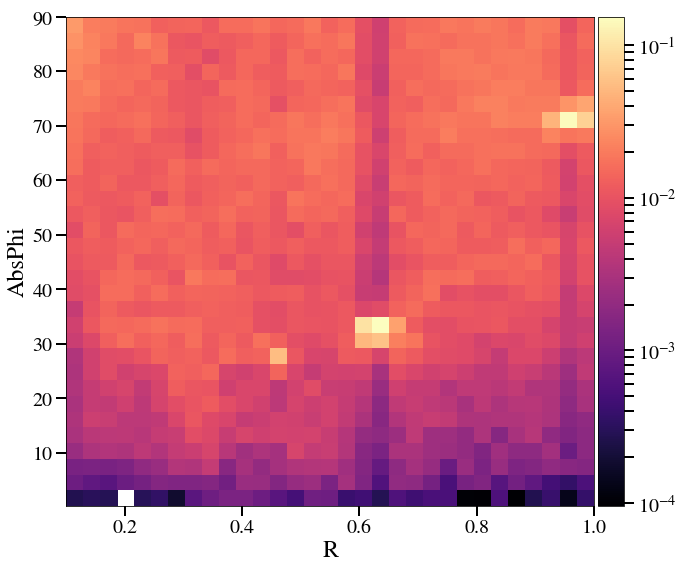

In [25]:
hist2d, x_edges, y_edges = w_set[sim_name].histogram2d(
    'R',
    'AbsPhi',
    n_bins = 32,
    x_data_args = {
        'scale_key' : 'Rvir',
        'scale_a_power' : 1.,
        'scale_h_power' : -1.,
    },
    slices = ind,
    return_dist = True,
    normed = True,
    conditional_y = True,
#     classification = 'is_CGM_IP',
)

#### How the mass compares to the spherical mass

In [26]:
# Construct a pdf array for each r
y_mids = ( y_edges + 0.5*( y_edges[1] - y_edges[0] ) )[:-1]
pdf_per_x = pdf_spherical( y_mids )

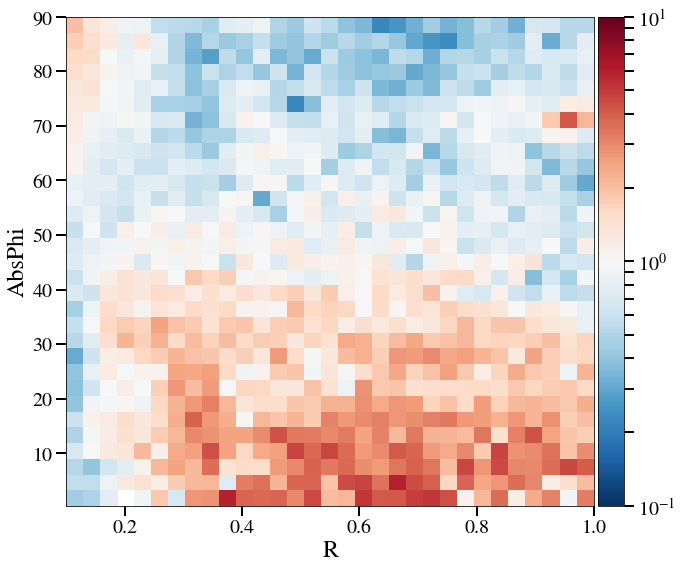

In [27]:

normed_hist2d, x_edge, y_edges = w_set[sim_name].histogram2d(
    'R',
    'AbsPhi',
    n_bins = 32,
    hist_div_arr = pdf_per_x,
    x_data_args = {
        'scale_key' : 'Rvir',
        'scale_a_power' : 1.,
        'scale_h_power' : -1.,
    },
    slices = ind,
    return_dist = True,
    classification = 'is_CGM_IP',
#     z_scale = 'linear',
    normed = True,
    conditional_y = True,
    cmap = cm.RdBu_r,
    vmin = 0.1,
    vmax = 10.,
)

## Plot Mass Compared to Spherical Mass
But for more sims

In [28]:
# Set up radial bins
# radial_bins = np.array([ 0.1, 0.4, 0.7, 1.0 ])
radial_bins = np.linspace( 0.1, 1., 32. )
r_mids = radial_bins[:-1] + 0.5 * ( radial_bins[1] - radial_bins[0] )

/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
# And angular bins
angular_bins = np.array([ 0., 45., 90. ])

In [30]:
# Choose the sims to plot
# sim_names = w_set.split_by_dict( linefinder_config.MASS_BINS )['m12'].keys()
sim_names = w_set.keys()

In [31]:
# Estimate the fraction of mass that should be in each bin
spherical_masses = {}
for i, phi_in in enumerate( angular_bins[:-1] ):
    spherical_mass = cdf_spherical( angular_bins[i+1] ) - cdf_spherical( phi_in )
    spherical_masses[phi_in] = spherical_mass

In [32]:
def get_fraction_data( w_set, additional_masks=None ):
    
    # Set up the data structure
    fraction_data = verdict.Dict( {} )
    for i, classification in enumerate( classification_list ):
        fraction_data[classification] = verdict.Dict( {} )

        for j, phi_in in enumerate( angular_bins[:-1] ):
            fraction_data[classification][phi_in] = verdict.Dict( {} )

            for k, sim_name in enumerate( sim_names ):
                fraction_data[classification][phi_in][sim_name] = np.zeros( r_mids.shape )

    for sim_name in w_set.keys():

        print( 'Calculating for {}'.format( sim_name ) )

        w = w_set[sim_name].data_object

        ## Set up Masks
        # Start from a fresh slate
        w.data_masker.clear_masks( True )
        # Choose only gas
        w.data_masker.mask_data( 'PType', data_value=linefinder_config.PTYPE_GAS )
        # Mask the angular data
        for i, phi_in in enumerate( angular_bins[:-1] ):

            if 'AbsPhi' not in w.data:
                w.calc_abs_phi( normal_vector=tot_momentums[sim_name] )

            # Mask the data not in this angular bin
            w.data_masker.mask_data(
                'AbsPhi',
                phi_in,
                angular_bins[i+1],
                optional_mask = True,
                mask_name = 'phi{}'.format( int( phi_in ) )
            )
        if additional_masks is not None:
            for mask in additional_masks:
                w.data_masker.mask_data( **mask )

        for classification in classification_list:

            # Get the radial distance values for all data
            r_all = w.get_selected_data(
                'R',
                classification = classification,
                scale_key = 'Rvir',
                scale_a_power = 1.,
                scale_h_power = -1.,
            )
            # Get the mass
            m_all = w.get_selected_data(
                'M',
                classification = classification,
            )
            # See how the mass is divided up.
            r_hist_all, edges = np.histogram(
                r_all,
                bins = radial_bins,
                weights = m_all,
                density = False,
            )

            # Get angular data
            for i, phi_in in enumerate( angular_bins[:-1] ):

                # Get the mass
                m = w.get_selected_data(
                    'M',
                    optional_masks = [ 'phi{}'.format( int( phi_in ) ), ],
                    classification = classification,
                )

                # Get the radial distance values
                r = w.get_selected_data(
                    'R',
                    optional_masks = [ 'phi{}'.format( int( phi_in ) ), ],
                    classification = classification,
                    scale_key = 'Rvir',
                    scale_a_power = 1.,
                    scale_h_power = -1.,
                )

                # See how the mass is divided up.
                r_hist, edges = np.histogram(
                    r,
                    bins = radial_bins,
                    weights = m,
                    density = False,
                )

                fraction_data[classification][phi_in][sim_name] = r_hist / r_hist_all

    return fraction_data

In [33]:
def plot_azimuthal_dep( ax, fraction_data, sim_name, add_labels=False, include_legend=False ):
    
    for classification in classification_list:
        
        class_data = fraction_data[classification]
        
        try:
            y_data = class_data[45.][sim_name]
        except KeyError:
            y_data = class_data['45.0'][sim_name]
        
        ax.plot(
            r_mids,
            y_data,
            linewidth = 3,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            label = p_constants.CLASSIFICATION_LABELS[classification],
        )
        
    trans = transforms.blended_transform_factory( ax.transAxes, ax.transData )
    ax.plot(
        [ 0., 1., ],
        [ spherical_masses[45.], spherical_masses[45.], ],
        linewidth = 3,
        color = 'k',
        linestyle = '--',
        transform = trans,
        zorder = -10.
    )

    ax.annotate(
        s = sim_name,
        xy = ( 0.95, 0.05, ),
        ha = 'right',
        va = 'bottom',
        xycoords = 'axes fraction',
        fontsize = 26,
    )
        
    ax.set_xlim( 0.1, 1. )
    ax.set_ylim( 0., 1. )
    
    if add_labels:
        ax.set_xlabel( r'$R/R_{\rm vir}$', fontsize=24 )
        ax.set_ylabel( r'$M_{\Phi>45\degree}/M$', fontsize=24)
    
    if include_legend:
        ax.legend(
            prop = { 'size': 20. }
        )

In [34]:
def combined_plot( 
    fraction_data, 
    save_file = None, 
    fraction_data_right = None,
    joint_sim_names = [ 'm12f', 'm12i', 'm12r_md', 'm12w_md',  ],
    left_label = None,
    right_label = None,
):

    n_rows = 4
    n_cols = 2

    fig = plt.figure( figsize=( 6*n_cols, 4*n_rows), facecolor='white' )
    ax = plt.gca()

    gs = gridspec.GridSpec( n_rows, n_cols )
    gs.update( wspace=0.02, hspace=0.05 )

    if fraction_data_right is not None:
        positions = {}
        i_values = {}
        for k, joint_sim_name in enumerate( joint_sim_names ):
            positions[joint_sim_name] = k
            i_values[joint_sim_name] = 0
            
        used_sim_names = copy.copy( joint_sim_names )
        used_sim_names.extend( used_sim_names )
    else:
        positions = {
            'm12f' : (0,0),
            'm12i' : (1,0),
            'm12m' : (0,1),
            'm12b_md' : (1,1),
            'm12c_md' : (0,2),
            'm12r_md' : (1,2),
            'm12w_md' : (0,3),
            'm12z_md' : (1,3),
        }
        used_sim_names = sim_names

    shared_ax = plt.subplot(gs[0,0])

    for sim_name in used_sim_names:

        # We only plot a subset of the simulations, specifically the m12 sims
        if sim_name not in positions.keys():
            continue

        if fraction_data_right is not None:
            j = positions[sim_name]
            i = copy.copy( i_values[sim_name] )
            i_values[sim_name] += 1
        else:
            i, j = positions[sim_name]
        
        ax = plt.subplot(gs[j,i], sharex=shared_ax, sharey=shared_ax )

        if ax.is_first_col() and ax.is_first_row():
            include_legend = True
        else:
            include_legend = False
            
        # Use different data for right column
        if ( fraction_data_right is not None) and ax.is_last_col():
            used_fraction_data = fraction_data_right
        else:
            used_fraction_data = fraction_data
            
        if fraction_data_right is not None:
            used_sim_name = joint_sim_names[j]
        else:
            used_sim_name = sim_name

        plot_azimuthal_dep( ax, used_fraction_data, used_sim_name, False, include_legend )

        # What is/isn't labeled
        if ax.is_last_col():
            ax.tick_params( labelleft = False, labelright=True )
        if not ax.is_last_row():
            ax.tick_params( labelbottom = False )
        if ax.is_first_row():
            ax.tick_params( labeltop = True )

        # Adjust tick labels
        if ax.is_last_row() or ax.is_first_row():
            x_tick_labels = ax.get_xticklabels()
            x_tick_labels[-1].set_horizontalalignment( 'right' )
        y_tick_labels = ax.get_yticklabels()
        y_tick_labels[0].set_verticalalignment( 'bottom' )
        y_tick_labels[-1].set_verticalalignment( 'top' )

        # Adjust ticks
        ax.tick_params(
            direction='in',
            which='both',
            top=True,
            right=True,
            length=7,
            labelsize=22,
        )

        # Add x- and y-labels
        if ax.is_first_row() and ax.is_first_col():
            ax.annotate(
                s = r'$R/R_{\rm vir}$',
                xy = ( 1., 1.2 ),
                ha = 'center',
                va = 'center',
                xycoords = 'axes fraction',
                fontsize = 30,
            )
        if ax.is_last_row() and ax.is_first_col():
            ax.annotate(
                s = r'$R/R_{\rm vir}$',
                xy = ( 1., -0.2 ),
                ha = 'center',
                va = 'center',
                xycoords = 'axes fraction',
                fontsize = 30,
            )
        y_label = r'$M(\Phi > 45\degree)/M$'
        if ax.is_last_col() and j == 1:
            ax.annotate(
                s = y_label,
                xy = ( 1.2, 0. ),
                ha = 'center',
                va = 'center',
                rotation = 'vertical',
                xycoords = 'axes fraction',
                fontsize = 30,
            )        
        if ax.is_first_col() and j == 1:
            ax.annotate(
                s = y_label,
                xy = ( -0.2, 0. ),
                ha = 'center',
                va = 'center',
                rotation = 'vertical',
                xycoords = 'axes fraction',
                fontsize = 30,
            )

        # Add annotations
        if ax.is_last_col() and j == 1:

            # Disk Line
            ax.annotate(
                s = 'disk-like',
                xy = ( 0.2, 1.0 ),
                xytext = ( 0., -12.0 ),
                textcoords = 'offset points',
                fontsize = 26,
                ha = 'left',
                va = 'top',
            )

            # Sphere line
            ax.annotate(
                s = 'spherical',
                xy = ( 0.2, spherical_masses[45.] ),
                xytext = ( 0., -10.0 ),
                textcoords = 'offset points',
                fontsize = 26,
                ha = 'left',
                va = 'top',
            )

            # Jet Line
            ax.annotate(
                s = 'jet-like',
                xy = ( 0.2, 0.0 ),
                xytext = ( 0., 12.0 ),
                textcoords = 'offset points',
                fontsize = 26,
                ha = 'left',
                va = 'bottom',
            )
        if ax.is_first_row():
            if fraction_data_right is not None:
                if ax.is_first_col() and ( left_label is not None):
                    ax.annotate(
                        s = left_label,
                        xy = ( 0.5, 1.125 ),
                        xycoords = 'axes fraction',
                        fontsize = 28,
                        va = 'bottom',
                        ha = 'center',
                    )
                elif ax.is_last_col() and ( right_label is not None):
                    ax.annotate(
                        s = right_label,
                        xy = ( 0.5, 1.125 ),
                        xycoords = 'axes fraction',
                        fontsize = 28,
                        va = 'bottom',
                        ha = 'center',
                    )
            
    if save_file is not None:
        plotting.save_fig(
            out_dir = file_manager.get_project_figure_dir(),
            save_file = save_file,
            fig = fig,
        )

# Load or Save Data

In [35]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'cgm_origins_azimuthal_dep_snum{}.hdf5'.format( snum ),
)

In [36]:
if do_calculation:
    # Get or save the data
    fraction_data = verdict.Dict( {
        'all': get_fraction_data( w_set ),
        'cold': get_fraction_data( 
            w_set, 
            additional_masks = [ {
                'data_key': 'T',
                'data_min': 0.,
                'data_max': 10.**4.7,
            }, ]
        ),
        'warmhot': get_fraction_data( 
            w_set.split_by_dict( linefinder_config.MASS_BINS )['m12'], 
            additional_masks = [ {
                'data_key': 'T',
                'data_min': 10.**4.7,
                'data_max': np.inf,
            }, ]
        ),
        'outflow': get_fraction_data( 
            w_set.split_by_dict( linefinder_config.MASS_BINS )['m12'], 
            additional_masks = [ {
                'data_key': 'Vr',
                'data_min': 1.,
                'data_max': np.inf,
                'scale_key': 'Vmax',
            }, ]
        ),
    } )
    
    fraction_data.to_hdf5(
        savefile,
        attributes = attributes,
    )

In [37]:
if not do_calculation:
    fraction_data, attributes = verdict.Dict.from_hdf5( 
        savefile, 
        load_attributes=True, 
    )

### For All Gas

File saved at /work/03057/zhafen/presentation_plots/blank_azimuthal_dep.pdf


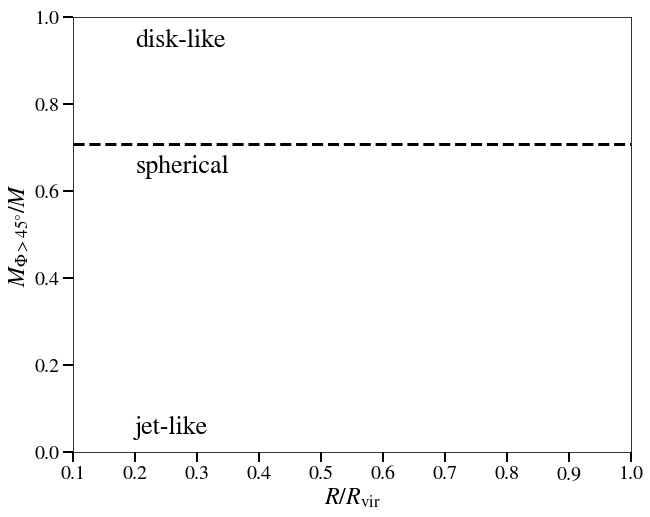

In [38]:
fig = plt.figure( figsize=(10,8), facecolor='white' )
ax = plt.gca()

trans = transforms.blended_transform_factory( ax.transAxes, ax.transData )
ax.plot(
    [ 0., 1., ],
    [ spherical_masses[45.], spherical_masses[45.], ],
    linewidth = 3,
    color = 'k',
    linestyle = '--',
    transform = trans,
    zorder = -10.
)

# Disk Line
ax.annotate(
    s = 'disk-like',
    xy = ( 0.2, 1.0 ),
    xytext = ( 0., -12.0 ),
    textcoords = 'offset points',
    fontsize = 26,
    ha = 'left',
    va = 'top',
)

# Sphere line
ax.annotate(
    s = 'spherical',
    xy = ( 0.2, spherical_masses[45.] ),
    xytext = ( 0., -10.0 ),
    textcoords = 'offset points',
    fontsize = 26,
    ha = 'left',
    va = 'top',
)

# Jet Line
ax.annotate(
    s = 'jet-like',
    xy = ( 0.2, 0.0 ),
    xytext = ( 0., 12.0 ),
    textcoords = 'offset points',
    fontsize = 26,
    ha = 'left',
    va = 'bottom',
)

ax.set_xlim( 0.1, 1. )
ax.set_ylim( 0., 1. )

ax.set_xlabel( r'$R/R_{\rm vir}$', fontsize=24 )
ax.set_ylabel( r'$M_{\Phi>45\degree}/M$', fontsize=24)

plotting.save_fig(
    out_dir = file_manager.get_project_presentation_dir(),
    save_file = 'blank_azimuthal_dep.pdf',
    fig = fig,
)

File saved at /work/03057/zhafen/presentation_plots/azimuthal_fraction_m12i_snum465.pdf


/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


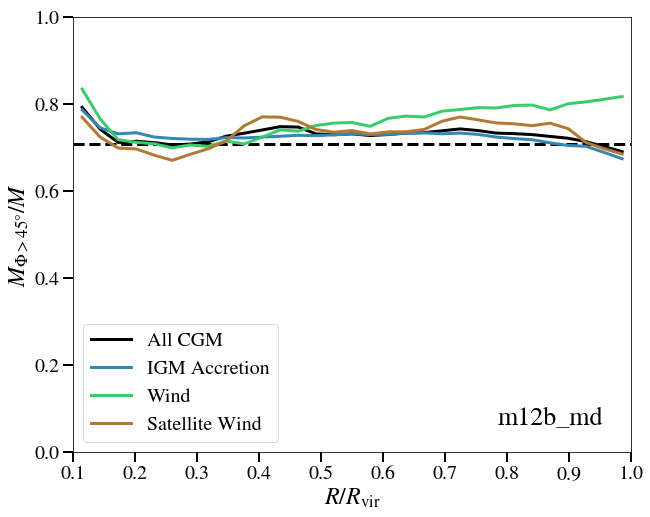

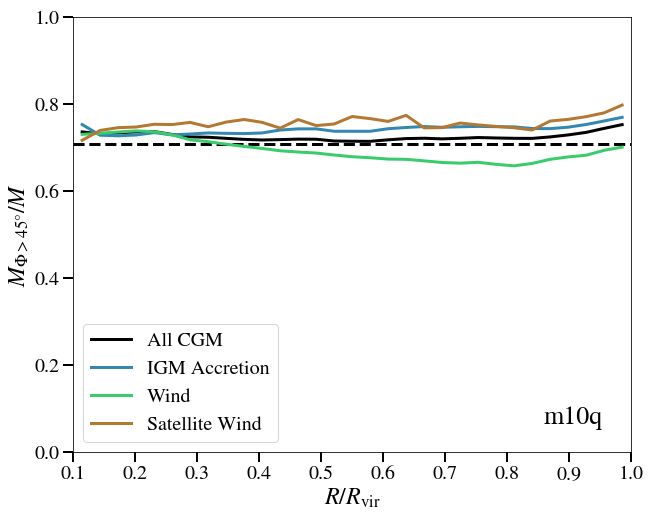

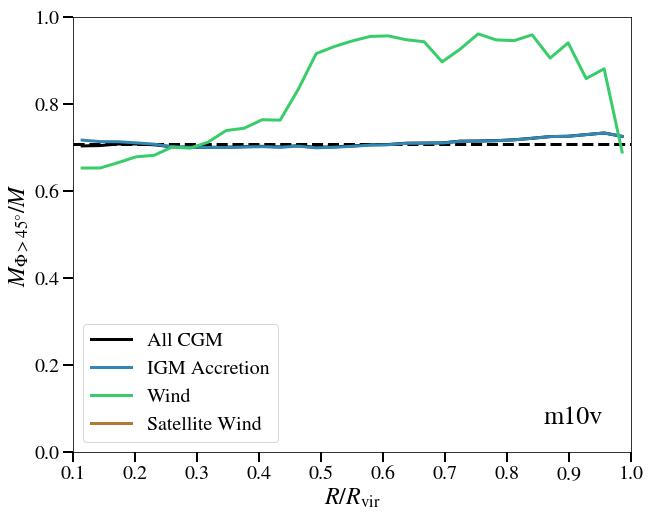

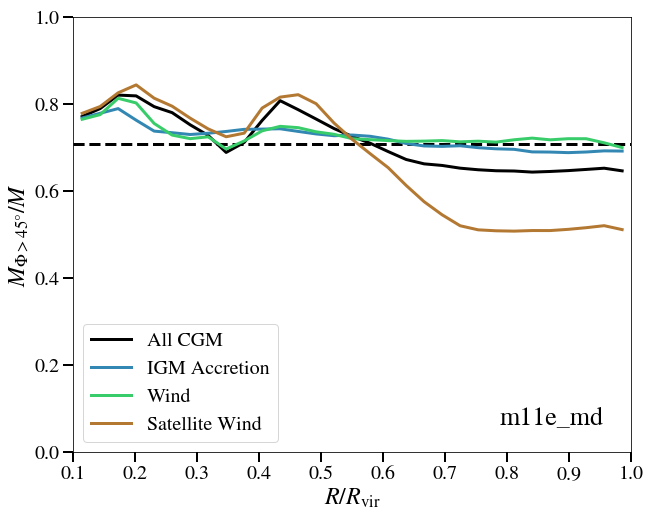

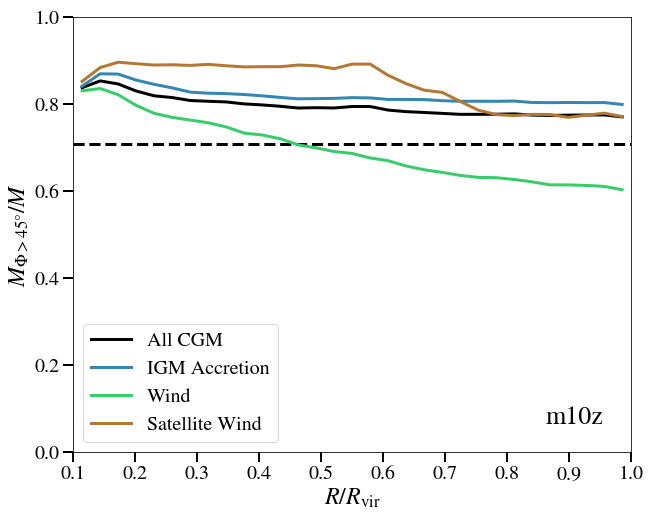

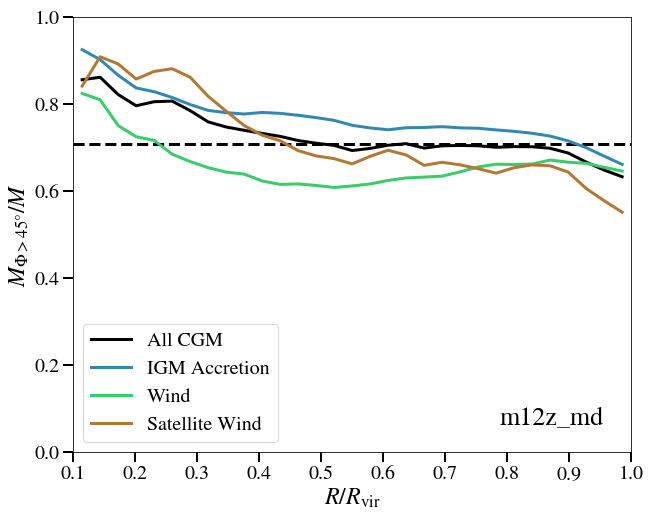

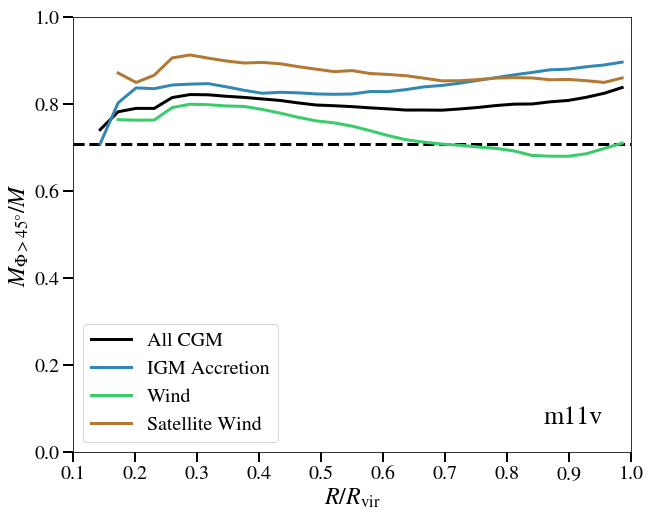

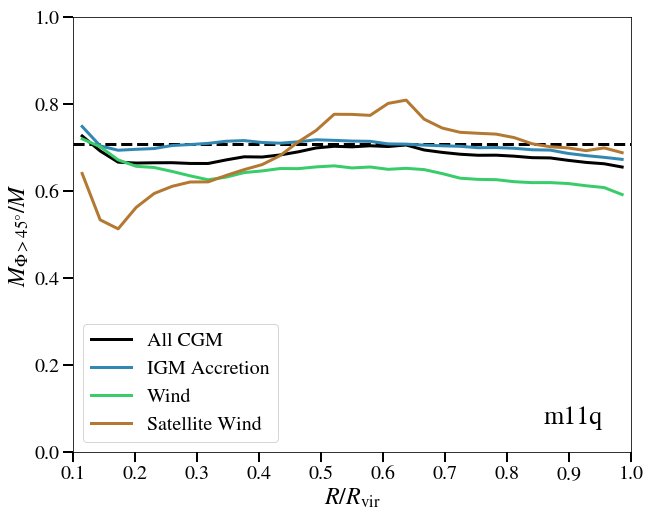

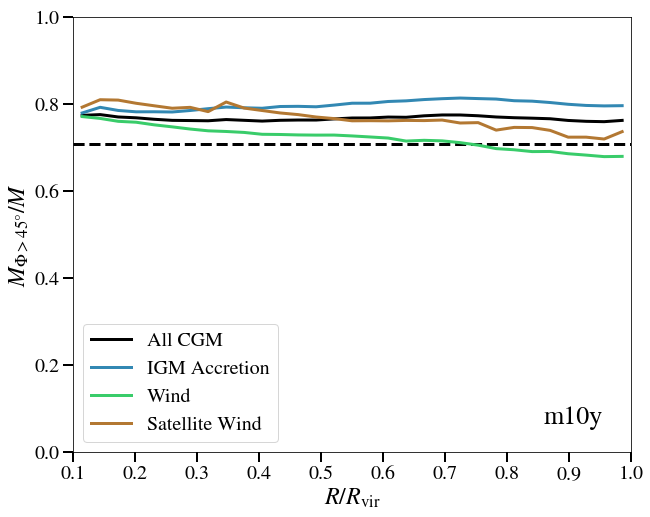

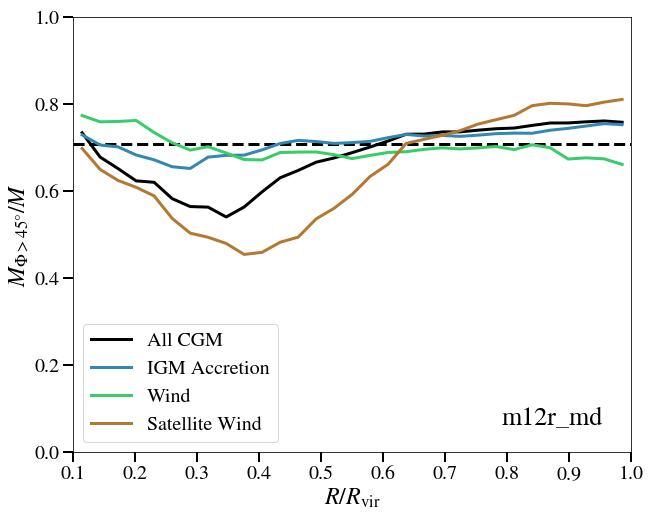

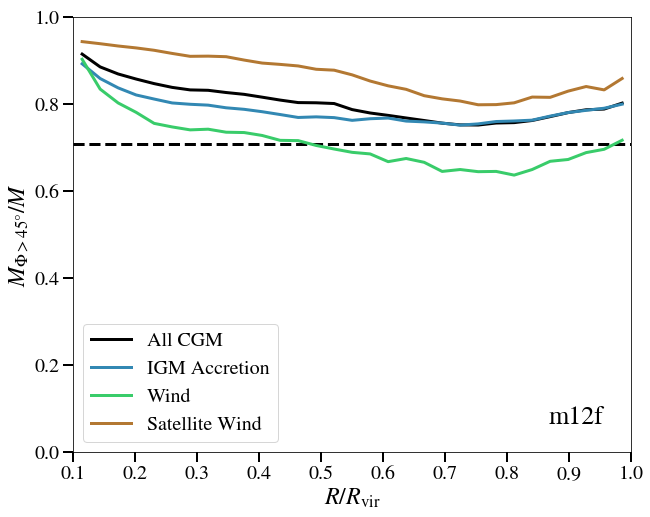

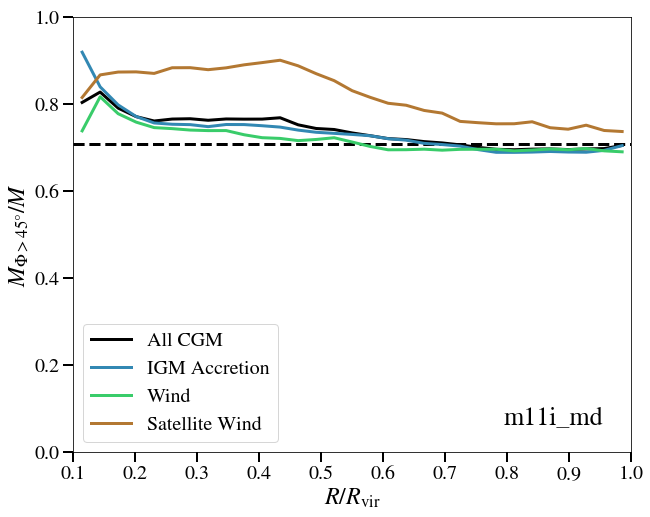

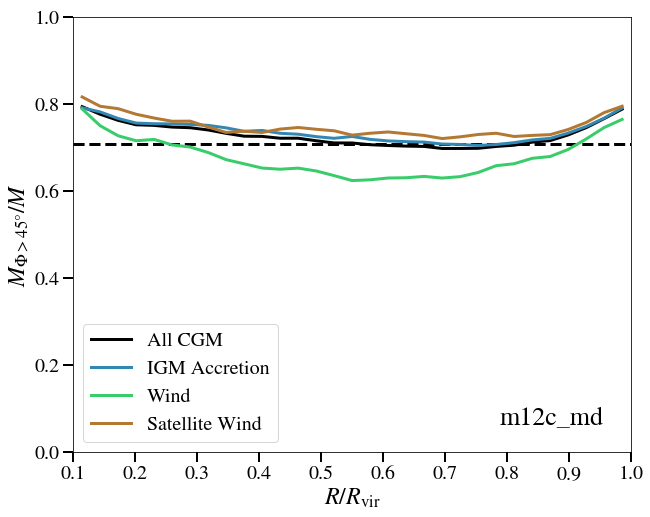

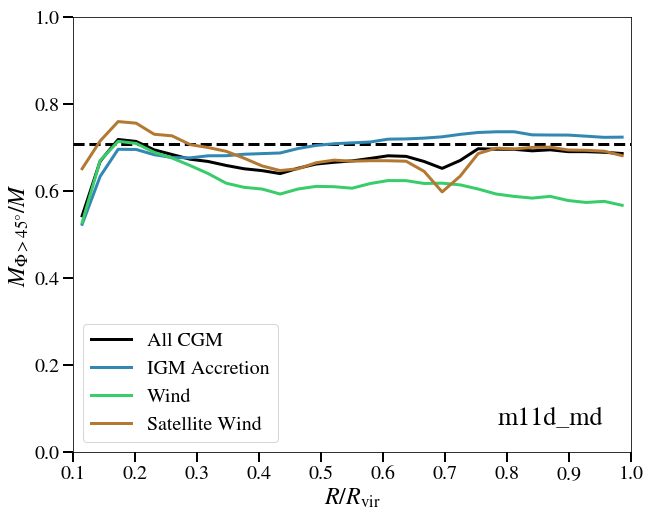

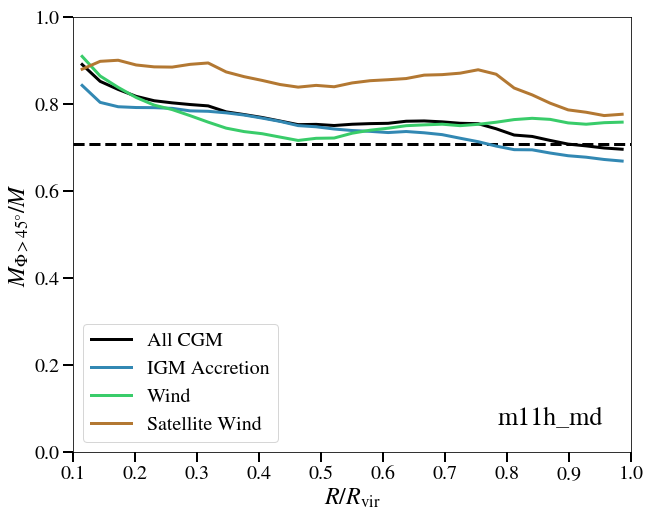

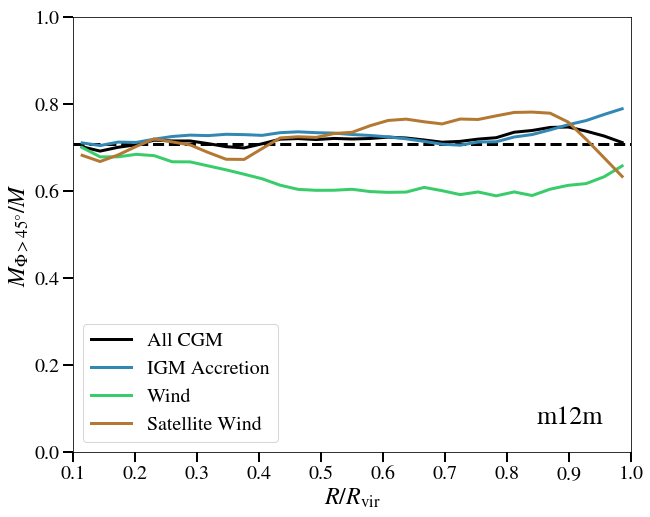

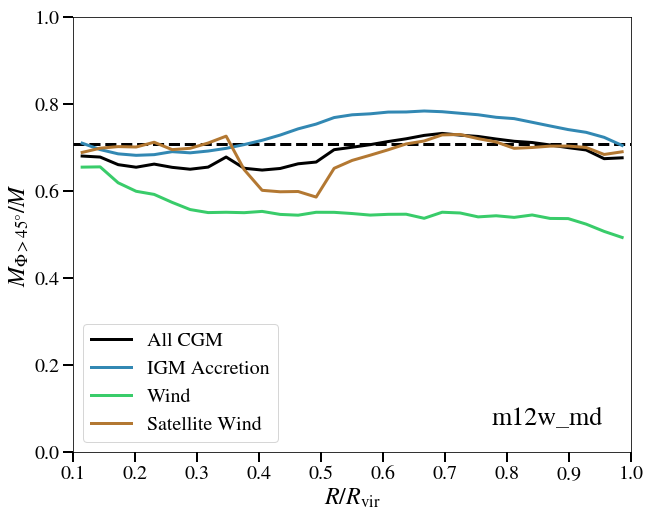

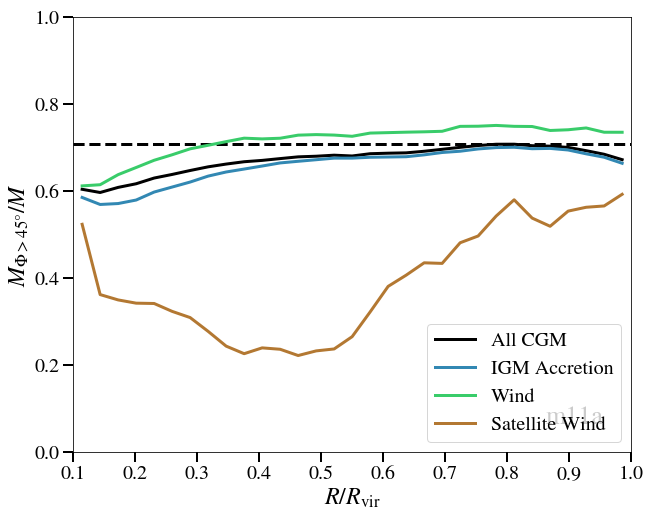

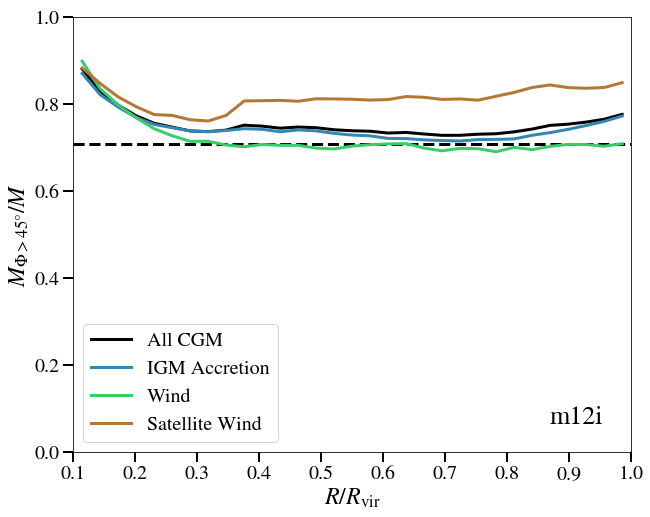

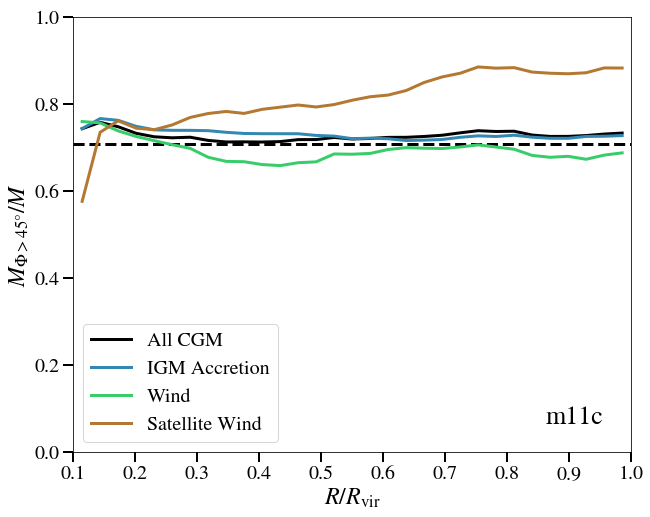

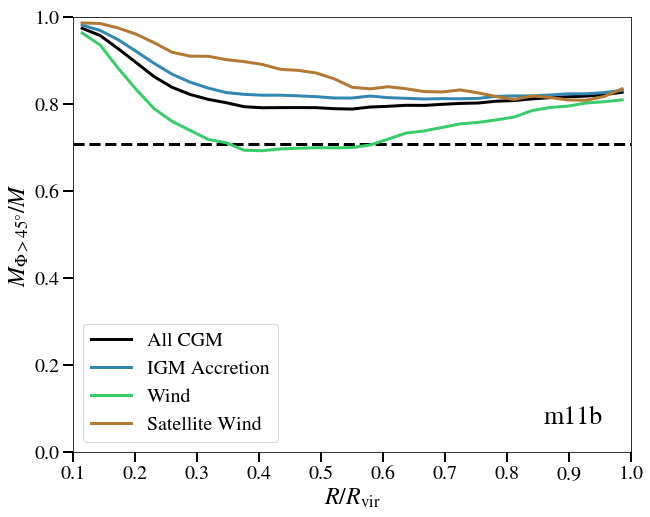

In [39]:
for sim_name in sim_names:
    
    fig = plt.figure( figsize=(10,8), facecolor='white' )
    ax = plt.gca()

    plot_azimuthal_dep( ax, fraction_data['all'], sim_name, True, True )
    
    if sim_name == 'm12i':
        plotting.save_fig(
            out_dir = file_manager.get_project_presentation_dir(),
            save_file = 'azimuthal_fraction_{}_snum{}.pdf'.format( sim_name, snum ),
            fig = fig,
        )

File saved at /home1/03057/zhafen/papers/CGM_origin/figures/CGM_m12_azimuthal_fractions_snum465.pdf


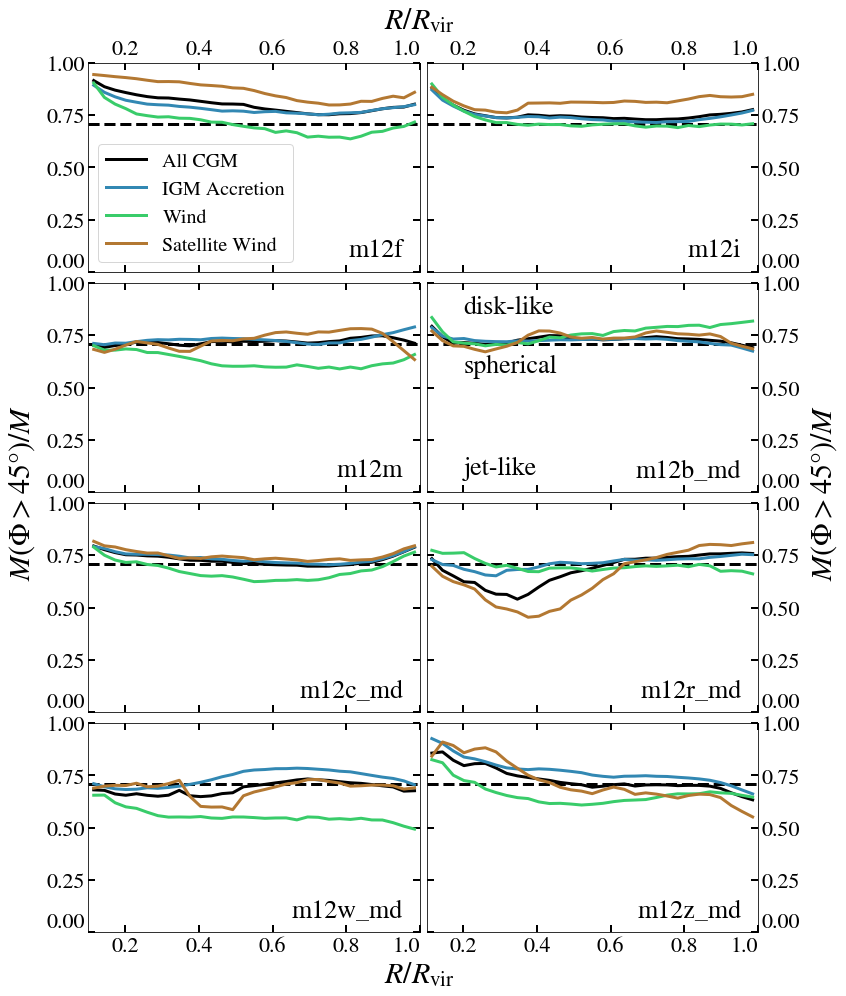

In [40]:
save_file = 'CGM_m12_azimuthal_fractions_snum{}.pdf'.format( snum )
combined_plot( fraction_data['all'], save_file=save_file )

### For Cold Gas

File saved at /home1/03057/zhafen/papers/CGM_origin/figures/CGM_m12_azimuthal_fractions_cold_snum465.pdf


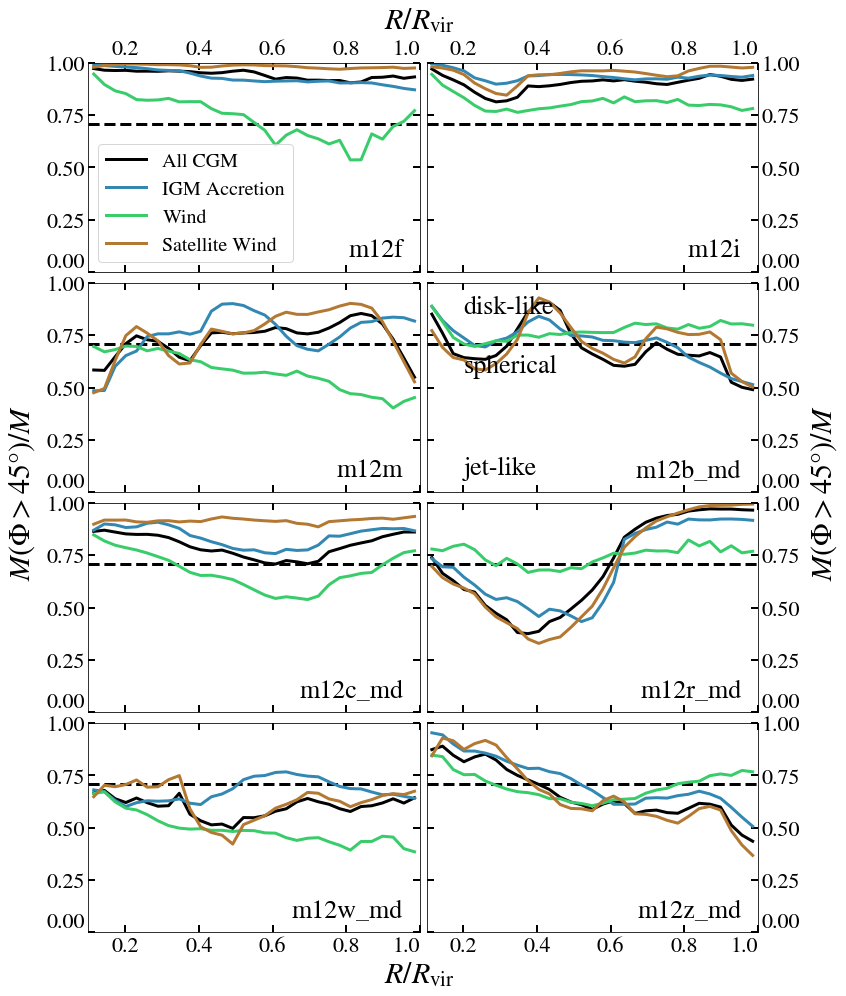

In [41]:
save_file = 'CGM_m12_azimuthal_fractions_cold_snum{}.pdf'.format( snum )
combined_plot( fraction_data['cold'], save_file=save_file )

### For Warm-Hot Gas

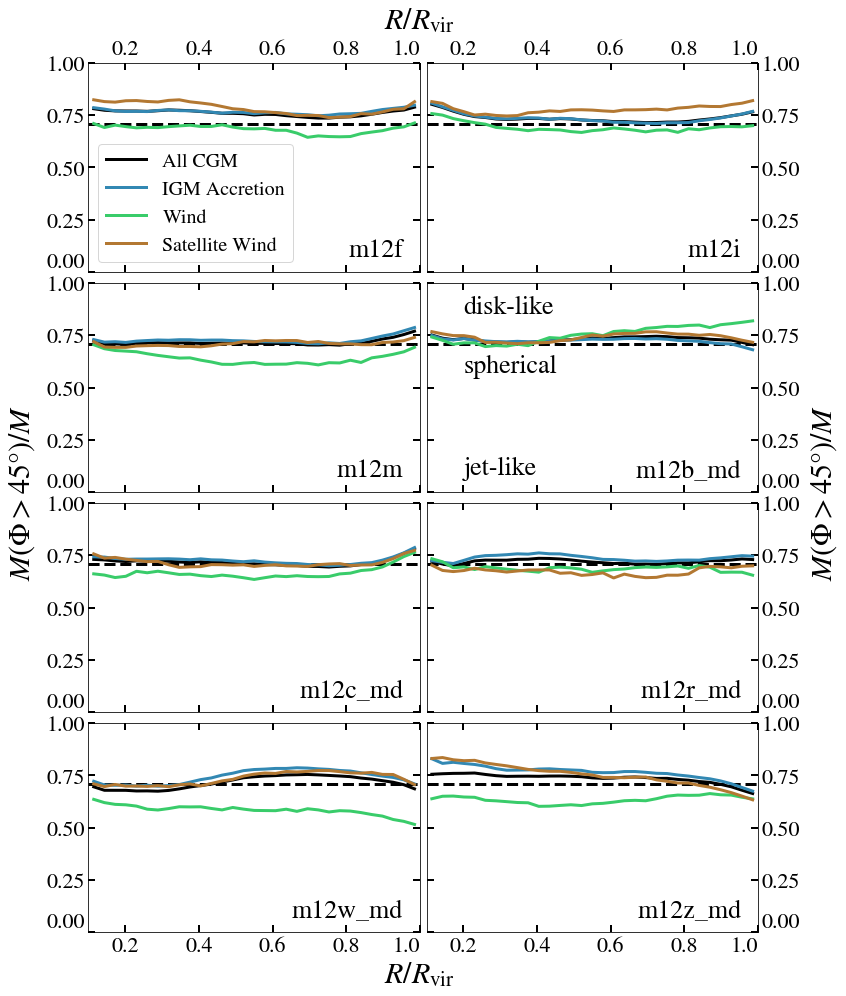

In [42]:
save_file = 'CGM_m12_azimuthal_fractions_warmhot_snum{}.pdf'.format( snum )
combined_plot( fraction_data['warmhot'], )

### Compare the Two

File saved at /home1/03057/zhafen/papers/CGM_origin/figures/CGM_m12_azimuthal_fractions_comparison_snum465.pdf


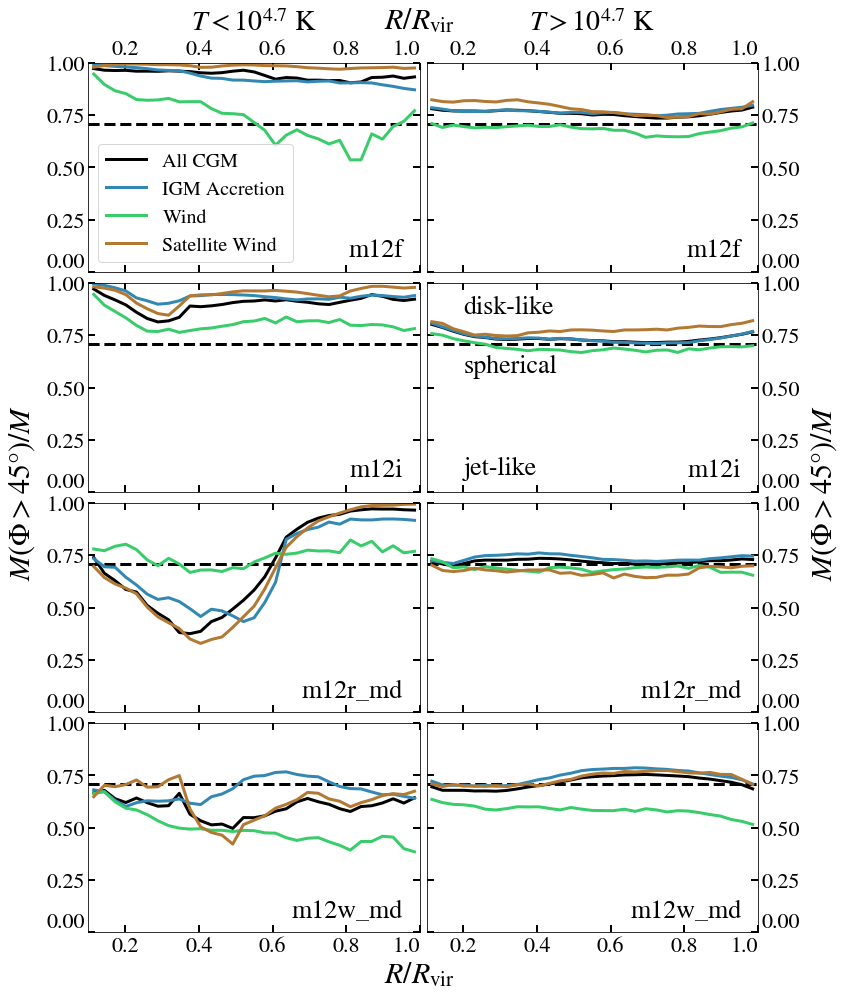

In [43]:
save_file = 'CGM_m12_azimuthal_fractions_comparison_snum{}.pdf'.format( snum )
combined_plot( 
    fraction_data['cold'], 
    fraction_data_right = fraction_data['warmhot'],
    left_label = r'$T < 10^{4.7}$ K',
    right_label = r'$T > 10^{4.7}$ K',
    save_file = save_file,
)

### Outwards Moving Gas

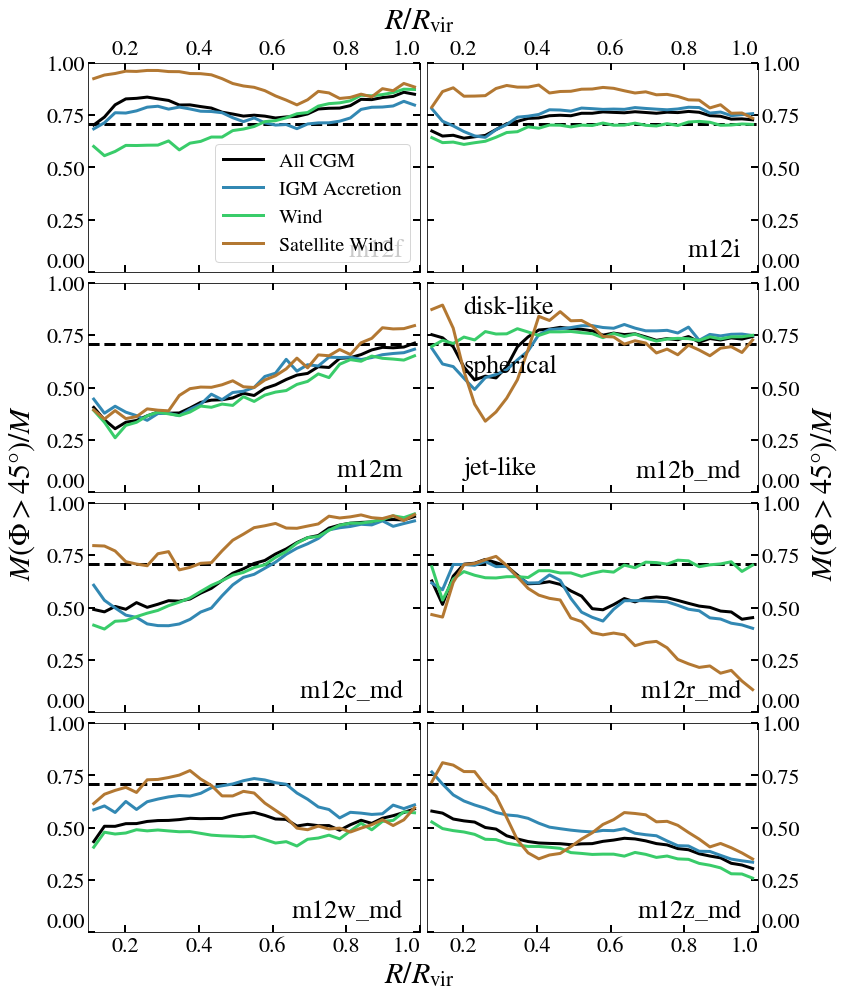

In [44]:
combined_plot( fraction_data['outflow'] )

## Full Angular Profiles

In [45]:
if plot_full_dist:

    # Start from a fresh slate
    w_set.data_object.data_masker.clear_masks( True )
    # Choose only gas
    w_set.data_object.data_masker.mask_data( 'PType', data_value=linefinder_config.PTYPE_GAS )

In [46]:
if plot_full_dist:

    hists = {}

    bins = np.linspace( 0., 90., 256 )
    for version in [ 1, 2, ]:

        fig = plt.figure( figsize=(10,16), facecolor='white' )
        main_ax = plt.gca()

        gs = matplotlib.gridspec.GridSpec( len( classification_list ), 1, )

        gs.update(wspace=0.025, hspace=0.0001)

        y_max = 0
        for i, classification in enumerate( classification_list ):

            hists[classification] = verdict.Dict( {} )

            ax = plt.subplot( gs[i,0] )

            for sim_name, w_plotter in w_set.items():

                # Plot only some simulations
                if version == 1:
                    if sim_name not in [ 'm10y', 'm11v', 'm12i', ]:
                        continue
    #             elif version == 2:
    #                 # Skip the outlier
    #                 if sim_name == 'm10z':
    #                     continue

                # Get the data
                w = w_plotter.data_object
                w.calc_abs_phi( normal_vector=tot_momentums[sim_name] )

                # Only plot when there's enough data
                n_class = w.get_selected_data( classification, sl=(slice(None),ind), ).sum()
                if n_class < 1000:
                    print( 'Insufficient {} for sim {}'.format( classification, sim_name ) )
                    continue

                # Color
                m_vir = halo_masses[sim_name]
                z_width = np.log10( z_max ) - np.log10( z_min )
                color_value = ( np.log10( m_vir ) - np.log10( z_min ) )/z_width
                color = cm.viridis( color_value )

                hist, edges = w_plotter.histogram(
                    'AbsPhi',
                    bins = bins,
                    weight_key = 'M',
                    ax = ax,
                    mask_zeros = True,
                    norm_type = 'probability',
                    smooth = True,
                    smoothing_window_length = 31,
                    histogram_style = 'line',
                    x_label = r'$\Phi$ $(\degree)$',
                    y_label = p_constants.CLASSIFICATION_LABELS[classification],
                #     bins = used_bins,
                    slices = ind,
                    plot_label = None,
                    color = color,
                    assert_contains_all_data = False,
                    classification = classification,
                    return_dist = True,
                )

                # Try and plot a spherical distribution
                phi_a = np.linspace( 0., 90., 1024 )
                y_spherical = pdf_spherical( phi_a )
                ax.plot(
                    phi_a,
                    y_spherical,
                    color = 'k',
                    linestyle = '--',
                    linewidth = 3,
                )

                # Track the maxes so we can set plot limits
                if hist.max() > y_max:
                    y_max = hist.max()

                # Store the data
                if version == 2:
                    hists[classification][sim_name] = hist

            # Adjust tick parameters
            ax.tick_params( direction='inout', which='both', top=True, )

            if classification != 'is_in_CGM':
                ax.yaxis.label.set_path_effects(
                    [
                        path_effects.Stroke(
                            linewidth=2,
                            foreground=p_constants.CLASSIFICATION_COLORS_B[classification]
            #                 foreground='k',
                        ),
                        path_effects.Normal() 
                    ]
                )

            # Add another x-axis label
            if i == 0:
                ax.annotate(
                    s = r'$\Phi$ $(\degree)$',
                    xy = ( 0.5, 1.17, ),
                    xycoords = 'axes fraction',
                    fontsize = 22,
                    ha = 'center',
                )

            # Add a label to the y axes
            if i == 0:

                formatted_redshift = '{:.02g}'.format( w.redshift.values[ind] )

                ax.annotate(
    #                 s = r'$\frac{d(M/M_{\rm tot})}{d(r/r_{\rm vir})}' + r'(z={})$'.format( formatted_redshift ),
                    s = r'PDF $' + r'(z={})$'.format( formatted_redshift ),
                    xy = ( 0, 1.2, ),
                    xycoords = 'axes fraction',
                    fontsize = 28,
                    ha = 'center',
                )

            # Hide labels
            if i != len( classification_list ) - 1:
                ax.tick_params( labelbottom = False )
            if i == 0:
                ax.tick_params( labeltop = True )

            # Avoid overlapping ticks
            ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
            ax.get_yticklabels()[-1].set_verticalalignment( 'top' )
        #     ax.set_yticklabels([0., 0.5, 1. ], va='top' )

        # Set limits
        for i, classification in enumerate( classification_list ):
            ax = plt.subplot( gs[i,0] )
            ax.set_xlim( 0., 90. )
            ax.set_ylim( 0., 1.05*y_max )

        # Add a colorbar
        sm = cm.ScalarMappable(
            cmap = cm.viridis,
            norm=colors.LogNorm( z_min, z_max ),
        )
        sm._A = []
        plotting.add_colorbar(
            fig,
            sm,
            method='fig',
            ax_location=[0.905, 0.125, 0.03, 0.76]
        )
        plt.subplot( gs[0,0] ).annotate(
            s = r'$M_{\rm h}$ $(M_{\odot})$',
            xy = (1., 1.2),
        #     xy = (1.15, 0.5),
            xycoords = 'axes fraction',
            fontsize = 22,
            ha = 'center',
        )

    #     if version == 1:
    #         save_file = 'CGM_profile_snum{}.pdf'.format( snum )

    #         plotting.save_fig(
    #             out_dir = file_manager.get_project_figure_dir(),
    #             save_file = save_file,
    #             fig = fig,
    #         )

## Plot Aggregate

In [47]:
if plot_full_dist:

    medians = {}

    fig = plt.figure( figsize=(10,16), facecolor='white' )
    main_ax = plt.gca()

    gs = matplotlib.gridspec.GridSpec( len( classification_list ), 1, )

    gs.update(wspace=0.025, hspace=0.0001)

    for i, classification in enumerate( classification_list ):

        medians[classification] = verdict.Dict( {} )

        y_max = 0

        sub_hists = hists[classification].split_by_dict( linefinder_config.MASS_BINS )

    #     plotted_colors = [ '#36a936', '#3636a9', '#a93636' ]
        plotted_colors = [ '#2820c6', '#0aa929', '#dfb707' ]
    #     plotted_colors = [ qual_colormaps.DARK2[j] for j in range(3) ]
        for mass_bin, color in zip( [ 'm10', 'm11', 'm12' ], plotted_colors ):

            if ( classification == 'is_CGM_EP' ) and ( mass_bin == 'm10' ):
                continue

            sub_hist = sub_hists[mass_bin]

            valid_regime = np.invert( np.isnan( sub_hist.array() ) ).sum( axis=0 ) >= 2

            sub_arr = sub_hist.array()

            ax = plt.subplot( gs[i,0] )

            median = np.nanmedian( sub_arr, axis=0 )
            ax.plot(
                bins[:-1],
                median,
                color = color,
                linewidth = 3,
                label = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
            )
            medians[classification][mass_bin] = median

            ax.fill_between(
                bins[:-1],
                np.nanmin( sub_arr, axis=0 ),
                np.nanmax( sub_arr, axis=0 ),
                color = color,
                alpha = 0.4,
            )

    #         ax.fill_between(
    #             used_bins,
    #             np.nanpercentile( sub_arr, 25, axis=0 ),
    #             np.nanpercentile( sub_arr, 75, axis=0 ),
    #             color = color,
    #             alpha = 0.4,
    #         )

            # Track the maxes so we can set plot limits
            hist_max = np.nanmax( sub_hist.array() )

        if hist_max > y_max:
            y_max = hist_max

            # Try and plot a spherical distribution
            phi_a = np.linspace( 0., 90., 1024 )
            y_spherical = pdf_spherical( phi_a )
            ax.plot(
                phi_a,
                y_spherical,
                color = 'k',
                linestyle = '--',
                linewidth = 3,
            )

        ax.set_xlabel(
            r'$\Phi$ $(\degree)$',
            fontsize = 22,
        )
        ax.set_ylabel(
            p_constants.CLASSIFICATION_LABELS[classification],
            fontsize = 22,
        )

        ax.set_xlim( 0., 90. )
        ax.set_ylim( 0., y_max, )
        ax.set_yscale( 'linear' )

        # Adjust tick parameters
        ax.tick_params( direction='inout', which='both', top=True, )

        # Rotate labels
    #     ax.yaxis.label.set_rotation( 'horizontal' )
    #     ax.yaxis.label.set_color(
    #         p_constants.CLASSIFICATION_COLORS_B[classification]
    #     )

        if classification != 'is_in_CGM':
            ax.yaxis.label.set_path_effects(
                [
                    path_effects.Stroke(
                        linewidth=2,
                        foreground=p_constants.CLASSIFICATION_COLORS_B[classification]
        #                 foreground='k',
                    ),
                    path_effects.Normal() 
                ]
            )

        # Add another x-axis label
        if i == 0:
            ax.annotate(
                s = r'$\Phi$ $(\degree)$',
                xy = ( 0.5, 1.17, ),
                xycoords = 'axes fraction',
                fontsize = 22,
                ha = 'center',
            )

        if i == 1:
            ax.legend(
                prop={'size': 18},
    #             loc = 'upper right',
            )

        # Add a label to the y axes
        if i == 0:

            formatted_redshift = '{:.02g}'.format( w.redshift.values[ind] )

            ax.annotate(
                s = r'$f(\Phi$ | origin, $ ' + r'z={})$'.format( formatted_redshift ),
                xy = ( 0, 1.2, ),
                xycoords = 'axes fraction',
                fontsize = 24,
                ha = 'center',
            )

        # Hide labels
        if i != len( classification_list ) - 1:
            ax.tick_params( labelbottom = False )
        if i == 0:
            ax.tick_params( labeltop = True )

        # Avoid overlapping ticks
        ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
        ax.get_yticklabels()[-1].set_verticalalignment( 'top' )
    #     ax.set_yticklabels([0., 0.5, 1. ], va='top' )

    # save_file = 'CGM_aggregate_profile_snum{}.pdf'.format( snum )
    # plotting.save_fig(
    #     out_dir = file_manager.get_project_figure_dir(),
    #     save_file = save_file,
    #     fig = fig,
    # )

In [48]:
if plot_full_dist:

    medians = {}

    fig = plt.figure( figsize=(10,16), facecolor='white' )
    main_ax = plt.gca()

    gs = matplotlib.gridspec.GridSpec( len( classification_list ), 1, )

    gs.update(wspace=0.025, hspace=0.0001)

    for i, classification in enumerate( classification_list ):

        medians[classification] = verdict.Dict( {} )

        y_max = 0

        class_hists = hists[classification].split_by_dict( linefinder_config.MASS_BINS )['m12']

        sub_arr = class_hists.array()

        ax = plt.subplot( gs[i,0] )

        median = np.nanmedian( sub_arr, axis=0 )
        ax.plot(
            bins[:-1],
            median,
            color = 'k',
            linewidth = 3,
        )

        ax.fill_between(
            bins[:-1],
            np.nanmin( sub_arr, axis=0 ),
            np.nanmax( sub_arr, axis=0 ),
            color = 'k',
            alpha = 0.2,
        )

        ax.fill_between(
            bins[:-1],
            np.nanpercentile( sub_arr, 16, axis=0 ),
            np.nanpercentile( sub_arr, 84, axis=0 ),
    #         np.nanpercentile( sub_arr, 50 - 68/2, axis=0 ),
    #         np.nanpercentile( sub_arr, 50 + 68/2, axis=0 ),        
            color = 'k',
            alpha = 0.2,
        )

        # Try and plot a spherical distribution
        phi_a = np.linspace( 0., 90., 1024 )
        y_spherical = pdf_spherical( phi_a )
        ax.plot(
            phi_a,
            y_spherical,
            color = 'k',
            linestyle = '--',
            linewidth = 3,
        )

        # Track the maxes so we can set plot limits
        hist_max = np.nanmax( class_hists.array() )

        if hist_max > y_max:
            y_max = hist_max

        ax.set_xlabel(
            r'Azimuthal Angle, $\Phi$ $(\degree)$',
            fontsize = 22,
        )
        ax.set_ylabel(
            p_constants.CLASSIFICATION_LABELS[classification],
            fontsize = 22,
        )

        ax.set_xlim( 0., 90. )
        ax.set_ylim( 0., 0.03, )
        ax.set_yscale( 'linear' )

        # Adjust tick parameters
        ax.tick_params( direction='inout', which='both', top=True, )

        # Rotate labels
    #     ax.yaxis.label.set_rotation( 'horizontal' )
    #     ax.yaxis.label.set_color(
    #         p_constants.CLASSIFICATION_COLORS_B[classification]
    #     )

        if classification != 'is_in_CGM':
            ax.yaxis.label.set_path_effects(
                [
                    path_effects.Stroke(
                        linewidth=2,
                        foreground=p_constants.CLASSIFICATION_COLORS_B[classification]
        #                 foreground='k',
                    ),
                    path_effects.Normal() 
                ]
            )

        # Add another x-axis label
        if i == 0:

            ax.annotate(
                s = r'$\Phi$ $(\degree)$',
                xy = ( 0.5, 1.17, ),
                xycoords = 'axes fraction',
                fontsize = 22,
                ha = 'center',
            )

        if i == 2:
            ax.legend(
                prop={'size': 18},
                loc = 'upper right',
            )

        # Add a label to the y axes
        if i == 0:

            formatted_redshift = '{:.02g}'.format( w.redshift.values[ind] )

            ax.annotate(
                s = r'$f(\Phi$ | origin, $ ' + r'z={})$'.format( formatted_redshift ),
                xy = ( 0, 1.2, ),
                xycoords = 'axes fraction',
                fontsize = 24,
                ha = 'center',
            )

        # Hide labels
        if i != len( classification_list ) - 1:
            ax.tick_params( labelbottom = False )
        if i == 0:
            ax.tick_params( labeltop = True )

        # Avoid overlapping ticks
        ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
        ax.get_yticklabels()[-1].set_verticalalignment( 'top' )
    #     ax.set_yticklabels([0., 0.5, 1. ], va='top' )

    save_file = 'CGM_aggregate_ang_dist_m12s_snum{}.pdf'.format( snum )
    plotting.save_fig(
        out_dir = file_manager.get_project_figure_dir(),
        save_file = save_file,
        fig = fig,
    )

# Analysis of the Plot

In [49]:
import py2tex.py2tex as py2tex

In [50]:
tex_filepath = os.path.join( file_manager.project_parameters['project_dir'], 'variables.tex' )

In [51]:
tex_file = py2tex.TeXVariableFile( tex_filepath )

In [52]:
# Used for variable names
if snum == 465:
    regime = 'low'
if snum == 172:
    regime = 'high'

### m12f

In [53]:
tex_file.save_variable(
    'mtwelvefIGMAccretionmedmassfrac{}'.format( regime ),
    '{:.2g}'.format( np.median( fraction_data['all']['is_CGM_IGM_accretion'][45.]['m12f'] ) )
)

KeyError: 45.0

In [ ]:
tex_file.save_variable(
    'mtwelvefsatwindmedmassfrac{}'.format( regime ),
    '{:.2g}'.format( np.median( fraction_data['all']['is_CGM_IGM_accretion'][45.]['m12f'] ) )
)